# Potato Disease Classification

<h2>Mehmet Omer DEMIR (2330938)</h2>

### Import all the Dependencies

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Seting all the Constants

In [69]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset 

I will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [70]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [71]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [72]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


### Visualize some of the images from our dataset

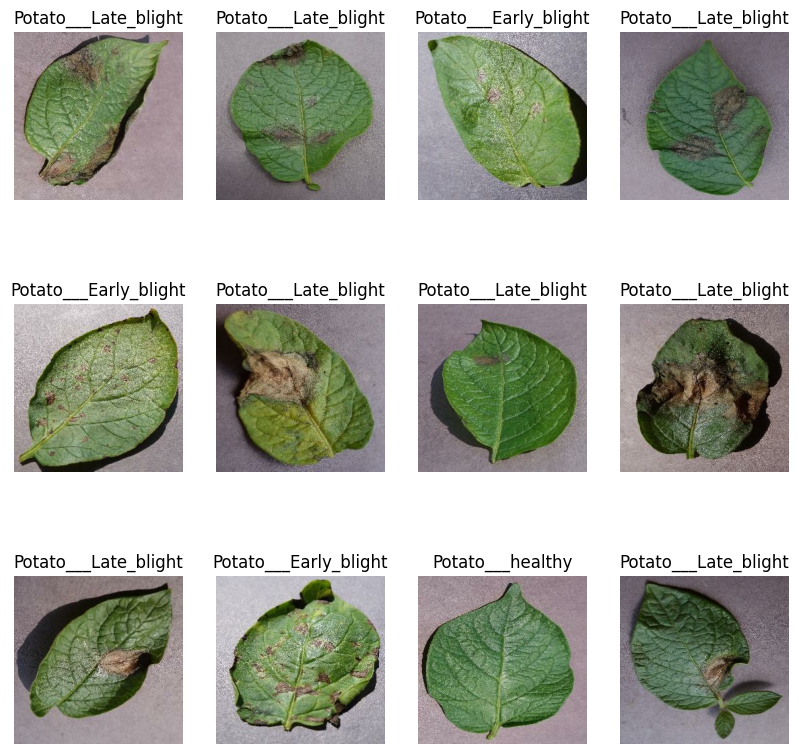

In [74]:

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [75]:
len(dataset)

68

In [76]:
train_size=0.8
len(dataset)*0.8

54.400000000000006

In [77]:
train_ds=dataset.take(54)
len(train_ds)

54

In [78]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [79]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [80]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [81]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [82]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [83]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [84]:
len(train_ds)

54

In [85]:
len(val_ds)

6

In [86]:
len(test_ds)

8

### Cache, Shuffle, and Prefetch the Dataset

In [88]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [89]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation


In [90]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [91]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


### Model Architecture
I use a CNN coupled with a Softmax activation in the output layer. I also add the initial layers for resizing, normalization and Data Augmentation.

In [92]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [93]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

### Compiling the Model
I use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [94]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [45]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 27s 501ms/step - loss: 0.2099 - accuracy: 0.9190 - val_loss: 0.1611 - val_accuracy: 0.9375
Epoch 2/50
54/54 [==============================] - 26s 473ms/step - loss: 0.1495 - accuracy: 0.9439 - val_loss: 0.1095 - val_accuracy: 0.9635
Epoch 3/50
54/54 [==============================] - 26s 469ms/step - loss: 0.1817 - accuracy: 0.9323 - val_loss: 0.2449 - val_accuracy: 0.9010
Epoch 4/50
54/54 [==============================] - 25s 462ms/step - loss: 0.1192 - accuracy: 0.9566 - val_loss: 0.1042 - val_accuracy: 0.9635
Epoch 5/50
54/54 [==============================] - 25s 463ms/step - loss: 0.1445 - accuracy: 0.9416 - val_loss: 0.1920 - val_accuracy: 0.9323
Epoch 6/50
54/54 [==============================] - 25s 462ms/step - loss: 0.0956 - accuracy: 0.9612 - val_loss: 0.5324 - val_accuracy: 0.8542
Epoch 7/50
54/54 [==============================] - 26s 480ms/step - loss: 0.0970 - accuracy: 0.9641 - val_loss: 0.1440 - val_accuracy: 0.9427

In [31]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 127ms/step - loss: 0.2022 - accuracy: 0.9258


**You can see above that we get 93% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [95]:
scores

[0.20215551555156708, 0.92578125]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [96]:
history

In [97]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [98]:
type(history.history['loss'])

list

In [99]:
len(history.history['loss'])

50

In [100]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.2099311798810959,
 0.14952270686626434,
 0.1817065179347992,
 0.1191675141453743,
 0.14445076882839203]

In [101]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

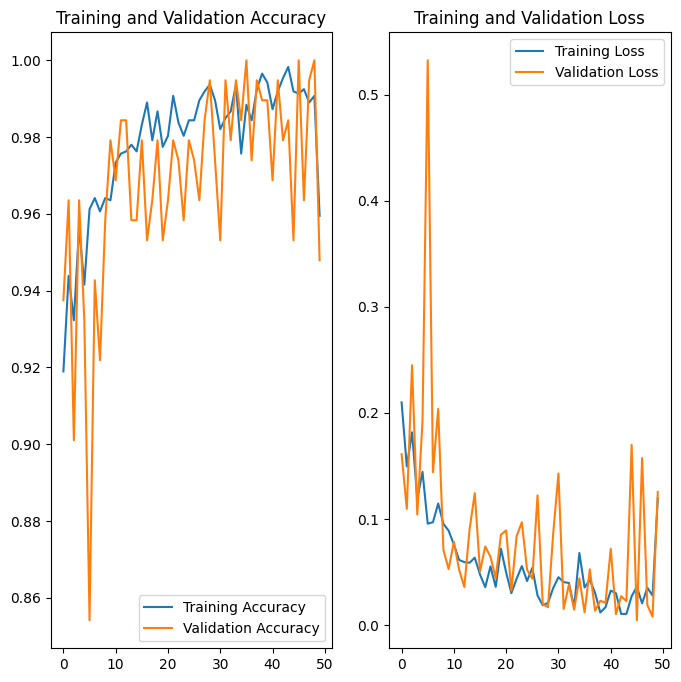

In [102]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Run prediction on a sample image    

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 179ms/step
predicted label: Potato___Early_blight


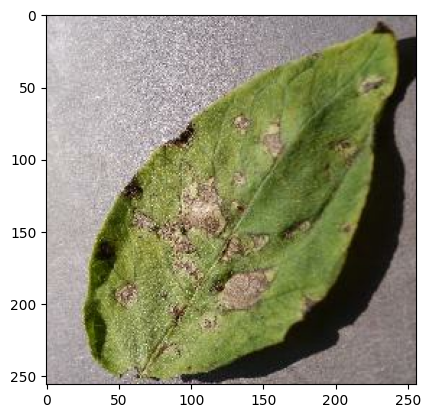

In [40]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [42]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 20ms/step


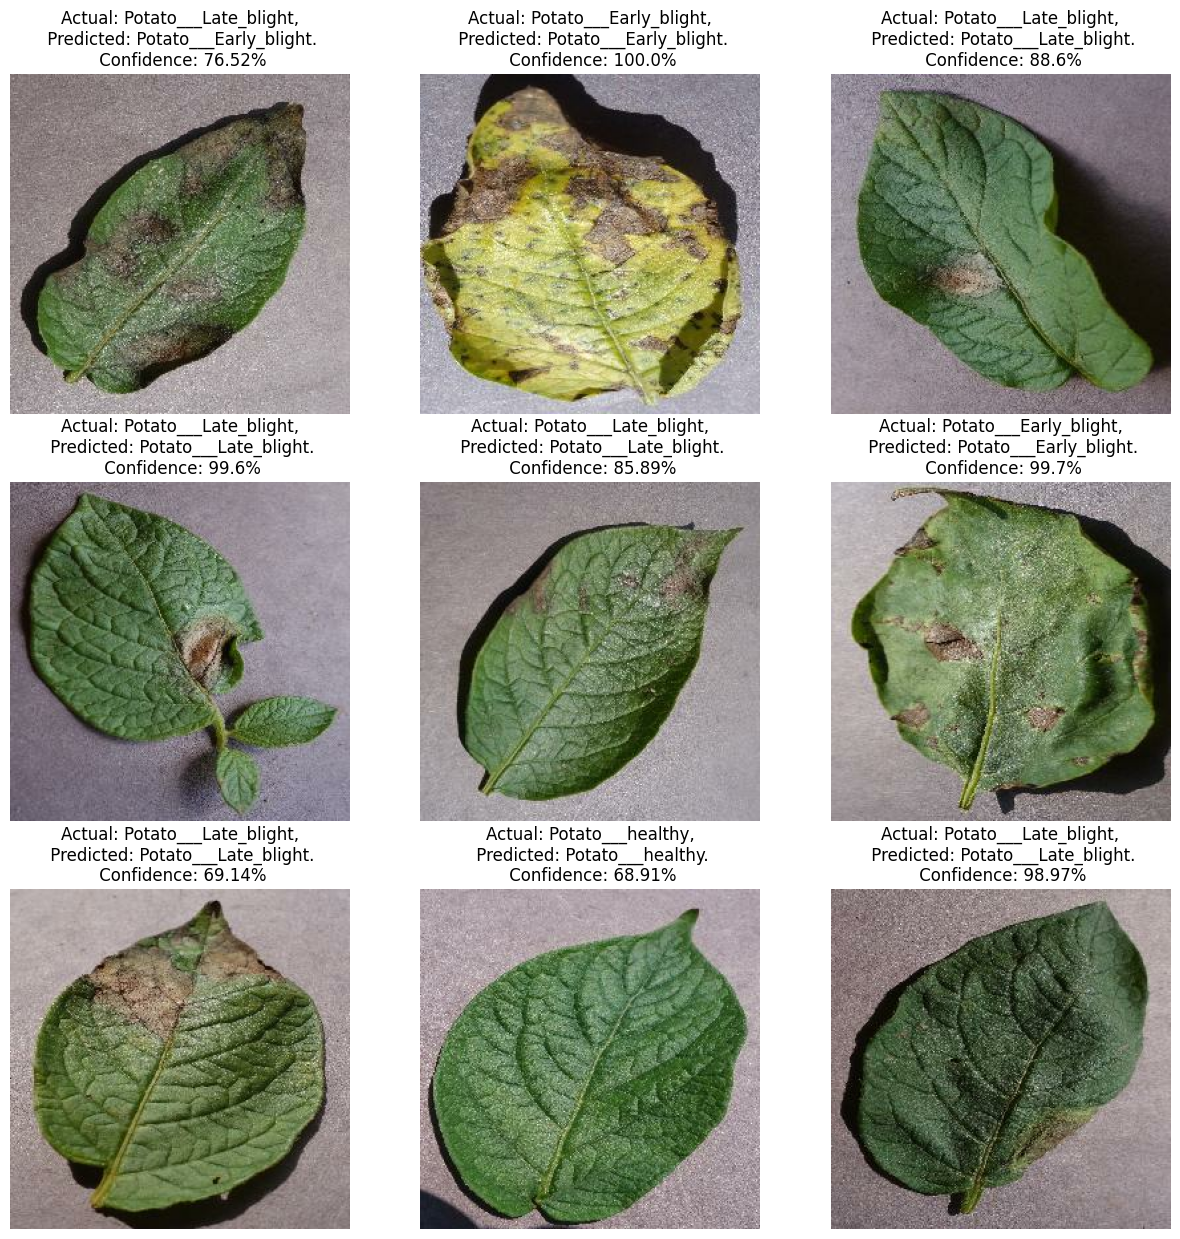

In [43]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

In [ ]:
model.save("../potatoes.h5")

/Users/mehmetomer/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
